In [222]:
import pandas as pd
import numpy as np
from os import path, listdir
from datetime import datetime
from scipy.stats import rankdata, ranksums, ks_2samp
import matplotlib.pyplot as plt

In [223]:
def load_pathways_genes():
    pathways = {}
    with open(pathway_file_dir, 'r') as f:
        for line in f:
            parts = line.strip().upper().split('\t')  # Split each line into parts
            if len(parts) < 3:  # If there are not enough parts for name, size, and genes
                continue

            pathway_name = parts[0]  # The pathway name is the first part
            try:
                pathway_size = int(parts[1])  # The pathway size is the second part
            except ValueError:
                continue  # Skip this line if the size is not an integer

            # Further split the gene part by spaces and then take the number of genes specified by pathway_size
            genes = parts[2]  # The third part is the space-separated list of gene IDs
            gene_list = genes.split()  # Split the genes by spaces

            # Convert each gene to an integer
            try:
                genes = [int(gene) for gene in gene_list[:pathway_size]]
            except ValueError:
                continue  # Skip this line if any gene is not an integer

            pathways[pathway_name] = genes  # Add the pathway and its genes to the dictionary

    return pathways


def get_scores():
    # Path to the file containing the raw scores (adjust as necessary)
    raw_scores_file_path = path.join(input_dir, f'{test_name}.xlsx')

    try:
        # Load raw data from the file
        raw_data = pd.read_excel(raw_scores_file_path)

        # Perform necessary preprocessing on raw_data
        # For instance, sorting, filtering, or extracting specific columns
        # Assuming 'GeneID' and 'Score' are columns in the raw data
        sorted_raw_data = raw_data.sort_values(by='GeneID').reset_index(drop=True)

        # Create a dictionary for gene_id_to_score
        scores_dict = {gene_id: score for gene_id, score in zip(sorted_raw_data['GeneID'], sorted_raw_data['Score'])}
        return scores_dict

    except FileNotFoundError:
        print(f"File not found: {raw_scores_file_path}")
        return pd.DataFrame(), {}
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame(), {}

In [224]:
def bh_correction(p_values):
    p_vals_rank = rankdata(p_values, 'max') - 1
    p_vals_rank_ord = rankdata(p_values, 'ordinal') - 1

    p_values_sorted = np.zeros_like(p_vals_rank)
    p_values_sorted[p_vals_rank_ord] = np.arange(len(p_vals_rank_ord))

    p_vals = p_values * (len(p_values) / (p_vals_rank + 1))
    adj_p_vals_by_rank = p_vals[p_values_sorted]

    p_vals_ordered = np.minimum(adj_p_vals_by_rank, np.minimum.accumulate(adj_p_vals_by_rank[::-1])[::-1])
    adj_p_vals = p_vals_ordered[p_vals_rank]
    return adj_p_vals

In [225]:
def perform_statist():
    scores = get_scores()

    significant_pathways_with_genes = {}
    ks_p_values = []
    pathway_names = []
    results = {}

    # Precompute scores keys for efficiency
    scores_keys = set(scores.keys())

    # Filter genes for each pathway, only includes genes that are in the experiment and in the pathway file
    genes_by_pathway_filtered = {
        pathway: [gene_id for gene_id in genes if gene_id in scores]
        for pathway, genes in genes_by_pathway.items()
    }

    # Filter pathways based on gene count criteria
    pathways_with_many_genes = [
        pathway for pathway, genes in genes_by_pathway_filtered.items()
        if minimum_gene_per_pathway <= len(genes) <= maximum_gene_per_pathway
    ]

    print('After filtering:', len(pathways_with_many_genes))

    # Perform statistical tests
    for pathway in pathways_with_many_genes:
        filtered_genes = set(genes_by_pathway_filtered[pathway])
        pathway_scores = [scores[gene_id] for gene_id in filtered_genes]
        background_scores = [scores[gene_id] for gene_id in scores_keys - filtered_genes]

        result = statistic_test(pathway_scores, background_scores)
        results[pathway] = result
        ks_p_values.append(result)
        pathway_names.append(pathway)

    # Apply BH correction
    adjusted_p_values = bh_correction(np.array(ks_p_values))

    # Filter significant pathways based on adjusted p-values
    for i, pathway in enumerate(pathway_names):
        if adjusted_p_values[i] < 0.05:  # Using a significance threshold of 0.05
            significant_pathways_with_genes[pathway] = (
            genes_by_pathway_filtered[pathway], adjusted_p_values[i], results[pathway]
            )

    return significant_pathways_with_genes, scores

In [226]:
def perform_statist_mann_whitney(pathways_with_many_genes, scores):
    mw_p_values = []
    significant_pathways_with_genes = {}

    scores_keys = set(scores.keys())

    # Mann-Whitney U test and FDR
    for pathway, genes_info in pathways_with_many_genes.items():
        pathway_genes = set(genes_info[0])
        pathway_scores = [scores[gene_id] for gene_id in pathway_genes]
        background_scores = [scores[gene_id] for gene_id in scores_keys - pathway_genes]

        # Perform Mann-Whitney U Test
        mw_pval = wilcoxon_rank_sums_test(pathway_scores, background_scores)
        mw_p_values.append(mw_pval)


    # Apply BH correction to Mann-Whitney p-values
    adjusted_mw_p_values = bh_correction(np.array(mw_p_values))

    filtered_pathways = []
    for i, (pathway, genes) in enumerate(pathways_with_many_genes.items()):
        if adjusted_mw_p_values[i] < 0.05:  # Significance threshold
            significant_pathways_with_genes[pathway] = genes
            filtered_pathways.append({
                'Pathway': pathway,
                'Adjusted_p_value': adjusted_mw_p_values[i],
                'Genes': genes[0]
            })

    # Convert filtered pathways to a DataFrame
    pathways_df = pd.DataFrame(filtered_pathways)
    pathways_df.sort_values(by='Adjusted_p_value', inplace=True)

    # Filter pathways based on Jaccard index
    filtered_pathways = {}
    for i, row in pathways_df.iterrows():
        current_genes = set(row['Genes'])
        if not any(jaccard_index(current_genes, set(filtered_row['Genes'])) > JAC_THRESHOLD
                   for filtered_row in filtered_pathways.values()):
            filtered_pathways[row['Pathway']] = row

    return filtered_pathways

In [227]:
def jaccard_index(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

In [228]:
def kolmogorov_smirnov_test(experiment_scores, control_scores):
    # Convert lists to numpy arrays and sort
    experiment_scores = np.sort(experiment_scores)
    control_scores = np.sort(control_scores)
    # Initialize variables
    en1 = len(experiment_scores)
    en2 = len(control_scores)

    # Calculate empirical cumulative distribution functions for both sets
    data_all = np.concatenate([experiment_scores, control_scores])
    cdf_experiment = np.searchsorted(experiment_scores, data_all, side='right') / en1
    cdf_control = np.searchsorted(control_scores, data_all, side='right') / en2

    # Find the maximum distance
    D = np.max(np.abs(cdf_experiment - cdf_control))
    # Calculate the KS statistic
    en = np.sqrt(en1 * en2 / (en1 + en2))
    p_value = ks((en + 0.12 + 0.11 / en) * D)

    return p_value


def ks(alam):
    EPS1 = 1e-6  # Convergence criterion based on the term's absolute value
    EPS2 = 1e-10  # Convergence criterion based on the sum's relative value
    a2 = -2.0 * alam ** 2  # Squared and negated lambda for exponential calculation
    fac = 2.0
    sum = 0.0
    termbf = 0.0

    # Iteratively calculate the KS probability
    for j in range(1, 101):
        term = fac * np.exp(a2 * j ** 2)  # Calculate term of the series
        sum += term  # Add to sum

        # Check for convergence
        if np.abs(term) <= EPS1 * termbf or np.abs(term) <= EPS2 * sum:
            return sum

        fac = -fac  # Alternate the sign
        termbf = np.abs(term)  # Update term before flag

    # Return 1.0 if the series does not converge in 100 terms
    return 1.0

In [229]:
def wilcoxon_rank_sums_test(experiment_scores, elements_scores, alternative='two-sided'):
    p_vals = ranksums(experiment_scores, elements_scores, alternative=alternative).pvalue
    return p_vals

In [230]:
def print_enriched_pathways_to_file(filtered_pathways, output_folder, threshold=0.05):
    
    output_file_path = path.join(output_folder, f'{test_name}.txt')
    significant_count = 0

    with open(output_file_path, 'w') as file:
        # file.write("Enriched Pathways:\n")
        # file.write("------------------\n")
        for pathway, details in filtered_pathways.items():
            p_value = details.get('Adjusted_p_value')
            if p_value and p_value < threshold:
                file.write(f"{pathway} {p_value}\n")
                significant_count += 1

        # file.write(f"===== {significant_count} enriched pathways\n")

In [231]:
def read_scores(file_name):
    """Reads scores from a given file into a dictionary."""
    return pd.read_csv(file_name, sep=' ', header=None, names=['Pathway', 'Score'], index_col='Pathway')[
        'Score'].to_dict()

In [232]:
def read_pathways(file_name):
    """Reads pathways from a given file into a dictionary."""
    with open(file_name, 'r') as file:
        return {line.split()[0]: [int(gene) for gene in line.split()[2:]] for line in file}

In [233]:
def process_experiment(condition_file, experiment_file, pathways_file):
    """Processes an experiment and returns scores, enriched pathway genes, and mean scores."""
    scores_dict = read_scores(condition_file)
    experiment_data = pd.read_excel(experiment_file)
    experiment_data_filtered = experiment_data[experiment_data['Score'] != 0]

    pathways = read_pathways(pathways_file)
    enriched_pathway_genes = {}
    pathway_mean_scores = {}

    for pathway, genes in pathways.items():
        filtered_genes = experiment_data_filtered[experiment_data_filtered['GeneID'].isin(genes)]
        if not filtered_genes.empty:
            enriched_pathway_genes[pathway] = filtered_genes.set_index('GeneID')[['Human_Name', 'Score']].to_dict(
                orient='index')
            # # create array of genes with score >=1.5 or <=-1.5
            filtered_genes_by_score = filtered_genes[2**(filtered_genes['Score'] >= 1.5) | (2**filtered_genes['Score'] <= -1.5)]
            # filtered_genes_by_score = filtered_genes[(filtered_genes['P-value(TvN)'] <= 0.05)]
            if not filtered_genes_by_score.empty:
                pathway_mean_scores[pathway] = filtered_genes_by_score['Score'].mean()
            else:
                pathway_mean_scores[pathway] = 0


    return scores_dict, enriched_pathway_genes, pathway_mean_scores

In [234]:
def calculate_trend(pathway_mean_scores):
    """Calculates the trend (up or down) of each pathway based on its mean score."""
    trends = {}
    for pathway, mean_score in pathway_mean_scores.items():
        trend = "Up" if mean_score > 0 else "Down"
        trends[pathway] = trend
    return trends

In [235]:
def bold_keywords(text, keywords):
    """Returns text with keywords in bold."""
    for keyword in keywords:
        if keyword in text:
            text = text.replace(text, f"**{text}**")
    return text

In [236]:
def print_pathway_information(condition, scores_dict, pathway_genes_dict, pathway_trends, output_dir, experiment_name):

    file_path = path.join(output_dir, 'Text', f'{experiment_name}.txt')
    with open(file_path, 'a') as file:
        file.write(f"Condition: {condition}\n------------------------\n")
        for pathway, p_value in scores_dict.items():
            trend = pathway_trends.get(pathway, "N/A")
            file.write(f"{pathway} (Trend: {trend}), P-Value: {p_value}\n")

            for gene_id, details in pathway_genes_dict.get(pathway, {}).items():
                if details['Score'] > 1 or details['Score'] < -1:
                    file.write(f"{details['Human_Name']} (ID: {gene_id}), Score: {details['Score']}\n")

            file.write("\n")

In [237]:
def plot_pathways_mean_scores(pathway_mean_scores_data, scores_dict, output_dir, experiment_name):
    """Plots mean scores of pathways across experiments in a grouped bar chart."""
    data_df = pd.DataFrame(pathway_mean_scores_data)

    # Increase the figure size significantly
    plt.figure(figsize=(60, 20))  # Adjust the size as needed
    ax = plt.subplot(111)

    conditions = list(pathway_mean_scores_data.keys())
    num_conditions = len(conditions)

    total_pathways = set()
    for condition in conditions:
        total_pathways.update(scores_dict[condition].keys())
    total_pathways = sorted(list(total_pathways))  # Sort pathways alphabetically
    num_pathways = len(total_pathways)

    bar_width = 0.8 / num_conditions
    positions = list(range(num_pathways))

    for i, condition in enumerate(conditions):
        mean_scores = data_df[condition].reindex(total_pathways)
        ax.bar([p + bar_width * i for p in positions], mean_scores, width=bar_width, label=condition)

    ax.set_xticks([p + bar_width * (num_conditions / 2) - bar_width / 2 for p in positions])

    # Removing underscores and applying bold formatting
    keywords = ['NEURO', 'SYNAP']
    formatted_pathways = [pathway.replace('_', ' ') for pathway in total_pathways]
    ax.set_xticklabels(formatted_pathways, rotation=90, fontsize=14)  # Increase fontsize for readability

    # Apply bold formatting based on keywords
    for label, pathway in zip(ax.get_xticklabels(), total_pathways):
        if any(keyword in pathway.upper() for keyword in keywords):
            label.set_weight('bold')

    ax.set_xlabel('Pathways', fontsize=16)
    ax.set_ylabel('Mean Scores', fontsize=16)
    ax.set_title('Pathway Mean Scores Across Different Conditions', fontsize=20)
    ax.legend(prop={'size': 14})

    plt.subplots_adjust(bottom=0.4)  # Adjust for layout

    # Define the output file path
    output_file_path = path.join(output_dir, "Plots", f'{experiment_name}_pathway_scores.pdf')

    # Save the plot to the specified directory
    plt.savefig(output_file_path, format='pdf', bbox_inches='tight')
    plt.show()

In [238]:
minimum_gene_per_pathway = 20
maximum_gene_per_pathway = 200
FDR_threshold = 0.05
JAC_THRESHOLD = 0.2
root_path = '/mnt/c/Users/pickh/PycharmProjects/Yair_propagation'
output_path = '/mnt/c/Users/pickh/PycharmProjects/Yair_propagation/Outputs'
figure_name = 'figure'
figure_title = 'Pathway Enrichment'
Experiment_name = 'Parkinson'
species = 'H_sapiens'
data_file = 'Data'
genes_names_file = 'H_sapiens.gene_info'  # optional if needed
date = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
pathway_file = 'pathways'
data_dir = path.join(root_path, data_file)
genes_names_file_path = path.join(data_dir, species, 'genes_names', genes_names_file)
pathway_file_dir = path.join(data_dir, species, 'pathways', pathway_file)
input_dir = path.join(root_path, 'Inputs', 'experiments_data', Experiment_name)
output_folder = path.join(root_path, 'Outputs', 'Temp')
statistic_test = kolmogorov_smirnov_test
genes_by_pathway = load_pathways_genes()

In [239]:
test_name = "roded_T_v_N"
print("running enrichment")
significant_pathways_with_genes, scores = perform_statist()

running enrichment
After filtering: 1059


In [240]:
filtered_pathways = perform_statist_mann_whitney(significant_pathways_with_genes, scores)

In [241]:
print("finished enrichment")
print_enriched_pathways_to_file(filtered_pathways, output_folder, FDR_threshold)

finished enrichment


In [242]:
test_name = "roded_500nm"
print("running enrichment")
significant_pathways_with_genes, scores = perform_statist()
filtered_pathways = perform_statist_mann_whitney(significant_pathways_with_genes, scores)
print("finished enrichment")
print_enriched_pathways_to_file(filtered_pathways, output_folder, FDR_threshold)

running enrichment
After filtering: 1059
finished enrichment


In [243]:
condition_files = [path.join(output_folder, file) for file in listdir(output_folder)]

In [244]:
test_file_paths = [f'{input_dir}/roded_500nm.xlsx', f'{input_dir}/roded_T_v_N.xlsx']

In [245]:
all_enriched_genes = {}
all_mean_scores = {}

In [246]:
for condition_file, experiment_file in zip(condition_files, test_file_paths):
    scores_dict, pathway_genes_dict, pathway_mean_scores = process_experiment(condition_file, experiment_file, pathway_file_dir)
    pathway_trends = calculate_trend(pathway_mean_scores)

    print_pathway_information(condition_file, scores_dict, pathway_genes_dict, pathway_trends, output_path, Experiment_name)

    all_enriched_genes[condition_file] = scores_dict
    all_mean_scores[condition_file] = pathway_mean_scores

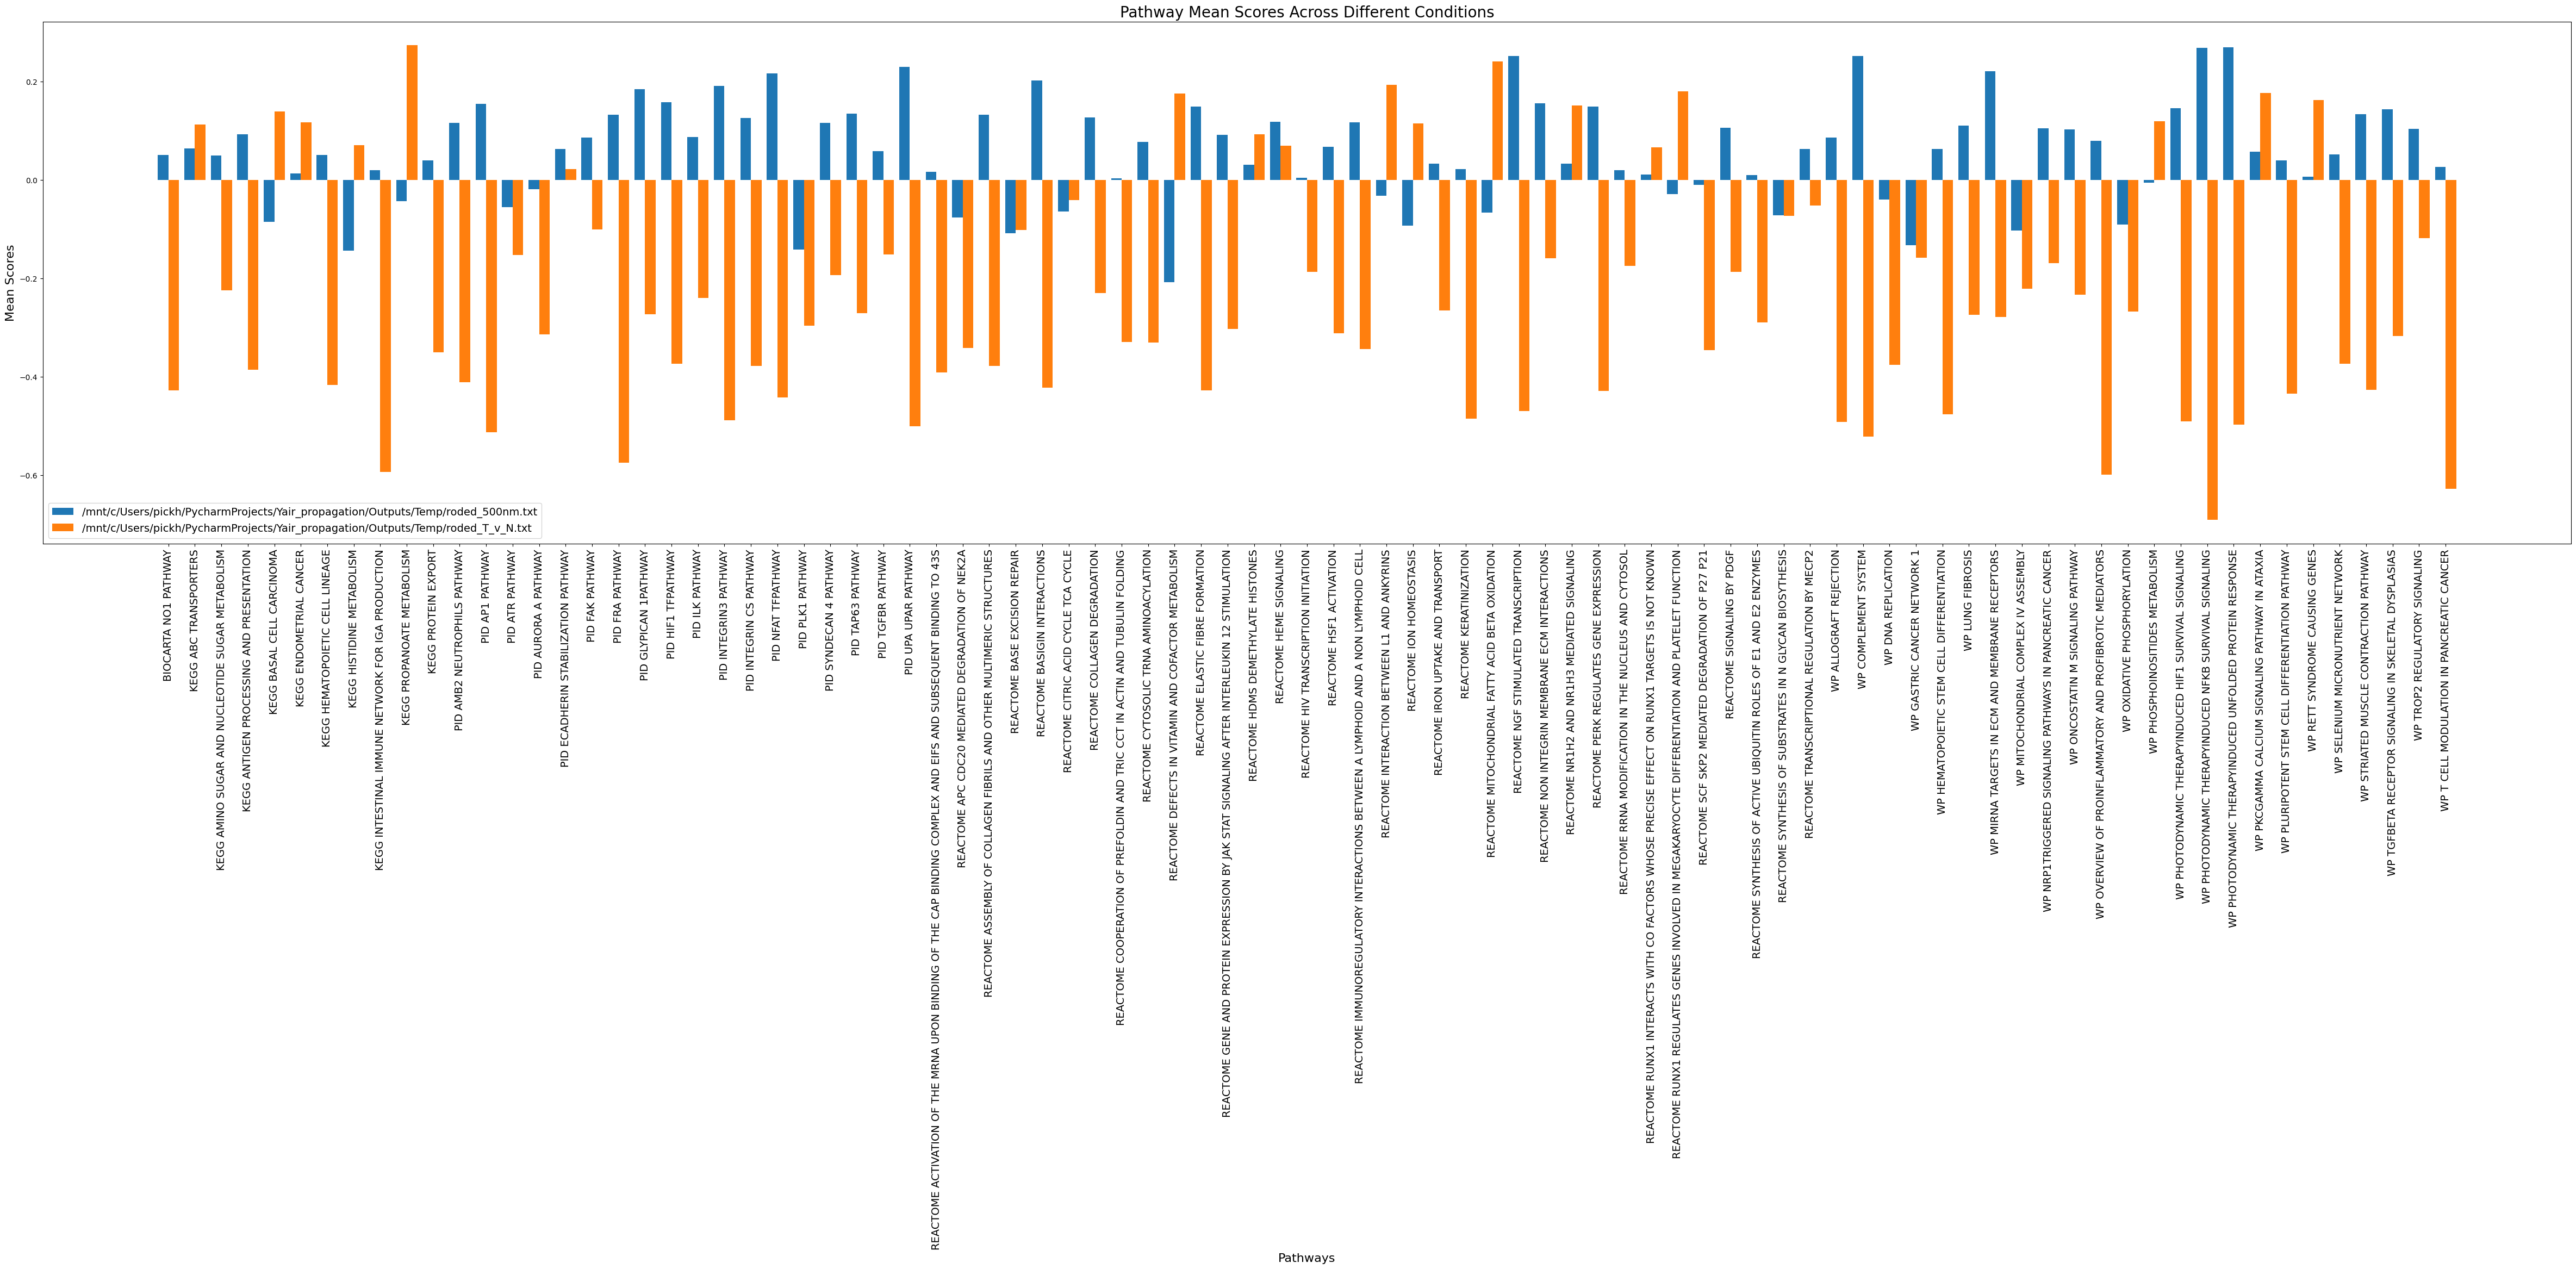

In [247]:
plot_pathways_mean_scores(all_mean_scores, all_enriched_genes, output_path, Experiment_name)